In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Rectangle, Polygon, Circle
from collections import deque
from collections import namedtuple, deque
import random
import torch.nn.functional as F
import torch.optim as optim



# Map of agent actions indices to vectors
ACTIONS = {
            0: np.array([-1, 0]),  # North
            1: np.array([0, 1]),  # East
            2: np.array([1, 0]),  # South
            3: np.array([0, -1]),  # West
            4: np.array([0, 0])  # wait
}

        
class Agent:
    
    def __init__(self, pos, env):
        self.pos = pos
        self.env = env
        self.state = 'active'
        self.invalid_move = False
        
    def render(self, r):
        pos = self.pos
        r.add_patch(Circle((self.pos[0] + 0.5, self.pos[1] + 0.5), radius=0.3, color='orange'))
        
        
class Goal:
    
    def __init__(self, pos):
        self.pos = pos
        
    def render(self, r):
        pos = self.pos
        r.add_patch(Rectangle((pos[0], pos[1]),
                              1, 1, color='green'))
        
        
class Cell:
    
    def __init__(self, pos, cap):
        self.pos = pos
        self.cap = cap

class Environment:
    
    def __init__(self, n, m, N_agents, goal_pos=None):
        assert N_agents < n*m, f'Not enough space available on the grid to place all agents:' +\
            f' {N_agents} agents for {n*m - 1} cells'
        
        self.n = n
        self.m = m
        self.cells = np.empty((n, m), dtype=Cell)
        
        # We instantiate every cells.
        for i in range(n):
            for j in range(m):
                self.cells[i, j] = Cell((i, j), [1])
                
        # We create empty array of Agents.
        self.agents = np.empty((N_agents), dtype=Agent)
        
        # For the moment, we instantiate only one Goal.
        if goal_pos is None:
            self.goals = [Goal((np.random.randint(n), np.random.randint(m)))]
        else:
            self.goals = [Goal(goal_pos)]
        
        # We instantiate every Agent at a random position, checking that this position
        # is not already occupied (by an other agent or by a Goal).
        for i in range(N_agents):
            rand_pos = (np.random.randint(n), np.random.randint(m))
            while rand_pos in [g.pos for g in self.goals] or\
            rand_pos in [a.pos for a in self.agents[np.where(self.agents != None)[0]]]:
                rand_pos = (np.random.randint(n), np.random.randint(m))
            self.agents[i] = Agent(rand_pos, self)
        
    def random_evolution(self):
        for i in range(len(self.agents)):
            agent = self.agents[i]
            if agent.state == 'active':
                self.agent_random_action(i)
            if tuple(agent.pos) in [goal.pos for goal in self.goals]:
                agent.state = 'success'
                
                
    def calculate_reward(self, agent_index, action_index):
        done = False
        reward = -0.5
        
        # Punish invalid movement -> Incentive for agent to walk within maze
        if self.agents[agent_index].invalid_move:
            reward -= 2
        
        if self.agents[agent_index].pos == self.goals[0].pos:
            done = True

        #reward -= np.sqrt((self.agents[agent_index].pos[0] - self.goals[0].pos[0])**2 + (self.agents[agent_index].pos[1] - self.goals[0].pos[1])**2)

        if action_index == 4:
             reward -= 2
        
        if done:
            reward = 10
        
        return reward, done
    
    def in_limits(self, pos):
        if pos[0] >= self.n or pos[0] < 0 or pos[1] >= self.m or pos[1] < 0:
            return False
        return True
    
    
    def agent_action(self, action_index, agent_index):
        agent = self.agents[agent_index]
        direction = ACTIONS[action_index]
        if action_index != 4:
            if self.allowed_movement(agent.pos + direction):
                agent.invalid_move = False
                agent.pos += direction
                agent.pos = tuple(agent.pos)
            else:
                agent.invalid_move = True
        
        reward, done = self.calculate_reward(agent_index, action_index)
        if done:
            self.agents[agent_index].state = 'success'
        return self.state(agent_index), reward, done
    
    def agent_random_action(self, agent_index):
        r = np.random.randint(len(ACTIONS))
        self.agent_action(r, agent_index)
    
    def allowed_movement(self, pos):
        active_agents = [a.state == 'active' for a in self.agents]
        active_agents = self.agents[np.where(active_agents)[0]]
        if self.in_limits(pos) and (tuple(pos) not in [a.pos for a in active_agents]):
            return True
        return False
    
    def state(self, agent_index):
        obs = np.zeros((3, self.n, self.m))# + CELL_STATE_TO_VALUE['empty']
#         obs_goal = np.zeros((1, self.n, self.m))# + CELL_STATE_TO_VALUE['empty']
        for i, agent in enumerate(self.agents):
            if i == agent_index:
                obs[0, agent.pos[0], agent.pos[1]] = 1
                return [agent.pos[0], agent.pos[1]]
            elif agent.state == 'active':
                obs[1, agent.pos[0], agent.pos[1]] = 1#CELL_STATE_TO_VALUE['agent']
                return [agent.pos[0], agent.pos[1]]
        for goal in self.goals:
            obs[2, goal.pos[0], goal.pos[1]] = 1#CELL_STATE_TO_VALUE['goal']
            
#         print(np.concatenate(obs_ag, obs_goal))
#         return np.concatenate((obs_ag, obs_goal))
        return agent.pos[0], agent.pos[1]
#         return np.concatenate((obs_ag.flatten(), obs_goal.flatten()))
    
    def render(self, fig, ax):
        ax.set_xticks(range(self.n + 1))
        ax.set_yticks(range(self.m + 1))
        img = np.zeros((self.m + 1, self.n + 1, 3), dtype=int) + 255
        for agent in self.agents:
            agent.render(ax)
        for goal in self.goals:
            goal.render(ax)
        ax.imshow(img)
        ax.grid()


In [3]:
state_observation_match = {tuple([0,0]): 0,
                                 tuple([0,1]): 1,
                                 tuple([0,2]): 2,
                                 tuple([0,3]): 3,
                                 tuple([0,4]): 4,
                                 tuple([1,0]): 5,
                                 tuple([1,1]): 6,
                                 tuple([1,2]): 7,
                                 tuple([1,3]): 8,
                                 tuple([1,4]): 9,
                                 tuple([2,0]): 10,
                                 tuple([2,1]): 11,
                                 tuple([2,2]): 12,
                                 tuple([2,3]): 13,
                                 tuple([2,4]): 14,
                                 tuple([3,0]): 15,
                                 tuple([3,1]): 16,
                                 tuple([3,2]): 17,
                                 tuple([3,3]): 18,
                                 tuple([3,4]): 19,
                                 tuple([4,0]): 20,
                                 tuple([4,1]): 21,
                                 tuple([4,2]): 22,
                                 tuple([4,3]): 23,
                                 tuple([4,4]): 24}

In [4]:
class QLearningAgent:
    def __init__(self, epsilon, learning_rate, gamma = 1.0):
        self.action_space = 5
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.q_table = np.zeros((25, 5))        

    def step(self, current_state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 4)
        else:     
            current_state = state_observation_match.get(tuple(current_state))                   
            return np.argmax(self.q_table[current_state])

    def update_q_learning_table(self, state, action, reward, next_state):

        current_state = state_observation_match.get(tuple(state))
        next_state_action_q = state_observation_match.get(tuple(next_state))
        updated_q = self.q_table[current_state][action] + self.learning_rate*(reward + (self.gamma*np.max(self.q_table[next_state_action_q])) - self.q_table[current_state][action])
        self.q_table[current_state][action] = updated_q

    def setGamma(self, gamma):
        self.gamma = gamma

    def setEpsilon(self, epsilon):
        self.epsilon = epsilon

In [5]:
gamma = 0.95
M = 5
N = 5
N_agents = 2
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32      # minibatch size
gamma = 0.99            # discount factor
tau = 0             # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4 


t_step = []
for i in range(N_agents):
  t_step.append(0)
all([False, False])
q_agents = []
for i in range(N_agents):
    q_agents.append(QLearningAgent(epsilon= 1, learning_rate = 0.2, gamma = 0.95))
q_learning_training_rewards = []
epsilon_values = []
env = Environment(M, N, N_agents, goal_pos=(4, 2))

for episode in range(5000):
  terminated = [False]*N_agents
  env = Environment(M, N, N_agents, goal_pos=(4, 2))
  total_reward = 0
  timestep = 0
  for step in range(1000):
    for i,agent in enumerate(env.agents):
        current_state = env.state(i)
        if terminated[i] == False:
            action = q_agents[i].step(current_state)
            observation, reward, terminated[i] = env.agent_action(action, i)
            #print('current_state: ', env.agent_pos, 'action: ', action)
            q_agents[i].update_q_learning_table(current_state, action, reward, observation)
            total_reward = total_reward + ((gamma **step ) * reward)
        
            if env.agents[i].pos == env.goals[0].pos:
                break
            #print('agent_pos ',env.agents[i].pos, ' goals pos ',env.goals[0].pos)
  q_agents[0].setEpsilon(epsilon = q_agents[i].epsilon*0.9994245)
  q_agents[1].setEpsilon(epsilon = q_agents[i].epsilon*0.9994245)
  q_learning_training_rewards.append(total_reward)
  epsilon_values.append(q_agents[0].epsilon)
    
    



In [6]:
print(q_agents[0].q_table)
print(q_agents[1].q_table)

[[ 2.48784188  4.1504696   4.95865028  2.42694763  1.86933576]
 [ 3.33393275  6.15336523  5.48845108  4.36907618  2.77591366]
 [ 4.06293613  5.2496957   7.08844984  5.29381772  4.0717763 ]
 [ 3.23374252  4.43584867  5.97089607  5.01174805  2.66505162]
 [ 2.45203228  2.44760473  4.36858435  4.96376996  1.98605574]
 [ 4.33855237  6.04299204  5.11071994  3.1962269   2.86254516]
 [ 5.24747244  6.62838516  6.26035542  5.14093766  4.02755861]
 [ 6.07576459  5.94408333  8.04024913  6.14126118  5.00263665]
 [ 5.15747664  5.05971961  7.03950494  5.47317953  3.93223552]
 [ 4.40817693  3.19284495  5.33178138  5.85547778  3.10270987]
 [ 5.15017279  6.58508501  6.94320758  4.0917604   3.97930468]
 [ 6.12729716  7.0605501   7.81800282  6.07838764  4.83086846]
 [ 7.00896702  7.00078959  8.99998606  6.77865023  5.98833564]
 [ 5.97963831  6.08847563  7.02178986  8.04500131  4.98900504]
 [ 5.29632542  4.1333864   6.23805935  6.98764608  4.11657063]
 [ 6.07036204  7.52985999  7.19775397  5.09821038  4.55

[0.9994245, 0.9988493312002501, 0.9982744934101444, 0.9976999864391869, 0.9971258100969912, 0.9965519641932804, 0.9959784485378872, 0.9954052629407537, 0.9948324072119313, 0.9942598811615809, 0.9936876845999725, 0.9931158173374852, 0.9925442791846075, 0.9919730699519368, 0.9914021894501795, 0.990831637490151, 0.9902614138827754, 0.989691518439086, 0.9891219509702244, 0.988552711287441, 0.9879837992020952, 0.9874152145256545, 0.986846957069695, 0.9862790266459015, 0.9857114230660668, 0.9851441461420923, 0.9845771956859876, 0.9840105715098704, 0.9834442734259665, 0.9828783012466099, 0.9823126547842426, 0.9817473338514143, 0.9811823382607829, 0.980617667825114, 0.9800533223572806, 0.979489301670264, 0.9789256055771528, 0.9783622338911432, 0.9777991864255389, 0.977236462993751, 0.9766740634092982, 0.9761119874858062, 0.9755502350370081, 0.9749888058767443, 0.9744276998189623, 0.9738669166777165, 0.9733064562671685, 0.9727463184015868, 0.9721865028953467, 0.9716270095629305, 0.9710678382189

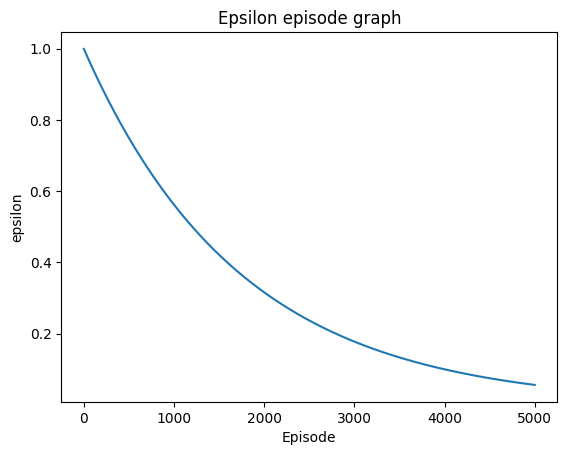

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
print(epsilon_values)

ax.plot(list(range(5000)), epsilon_values)

ax.set_xlabel('Episode')
ax.set_ylabel('epsilon')
ax.set_title('Epsilon episode graph')

# You can add more plots by indexing the axs object
# to access the right subplot and using a plotting function.
# ...

plt.show()

Text(0.5, 1.0, 'Reward per episode')

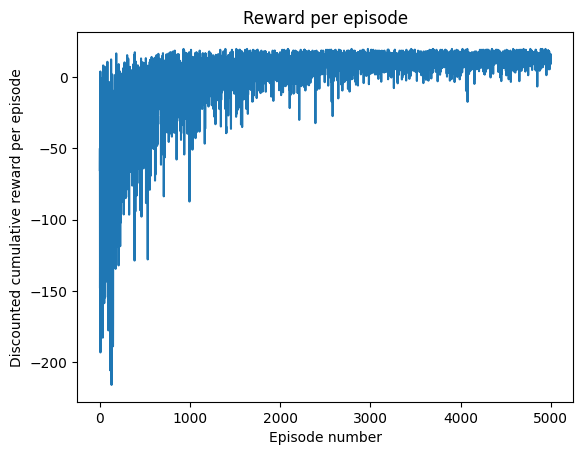

In [8]:
fig, ax = plt.subplots()

ax.plot(list(range(5000)), q_learning_training_rewards)

ax.set_xlabel('Episode number')
ax.set_ylabel('Discounted cumulative reward per episode')
ax.set_title('Reward per episode')

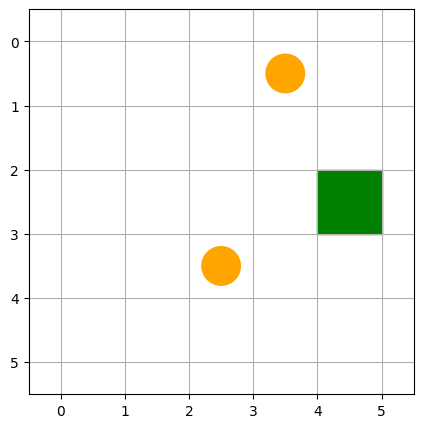

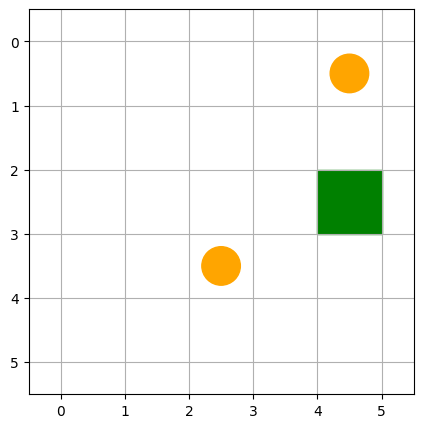

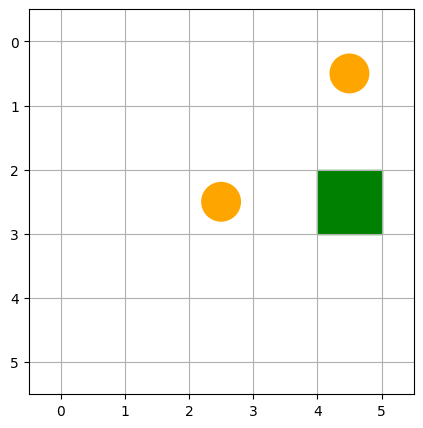

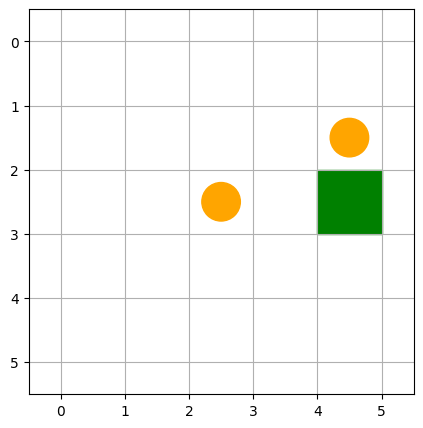

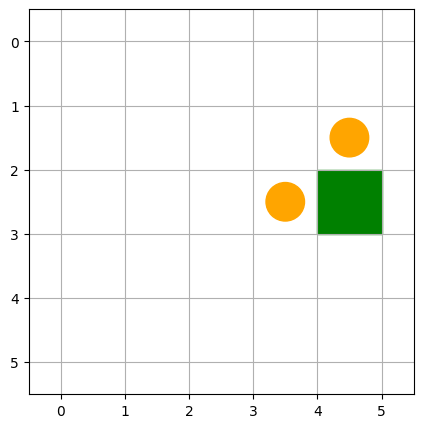

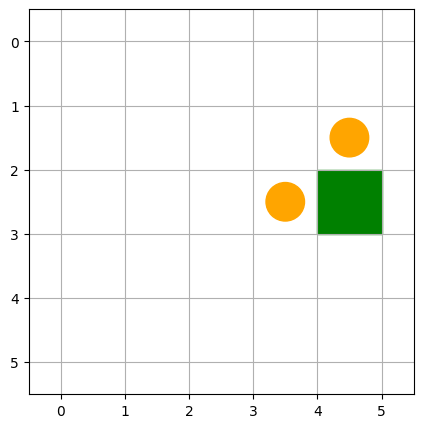

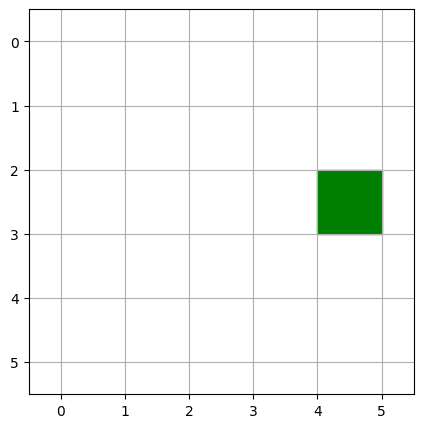

In [9]:
for i in range(N_agents):
  q_agents[i].setEpsilon(epsilon = 0)

terminated = [False]*N_agents
env = Environment(M, N, N_agents, goal_pos=(4, 2))
total_reward = 0
timestep = 0
for step in range(100):
  for i,agent in enumerate(env.agents):
      current_state = env.state(i)
      if terminated[i] == False:
          action = q_agents[i].step(current_state)
          observation, reward, terminated[i] = env.agent_action(action, i)
          #print('current_state: ', env.agent_pos, 'action: ', action)
          #q_agents[i].update_q_learning_table(current_state, action, reward, observation)
          total_reward = total_reward + ((gamma **step ) * reward)
      
          if env.agents[i].pos == env.goals[0].pos:
              break # Greedy action
          fig, ax = plt.subplots(1, 1, figsize=[5, 5])
          env.render(fig, ax)

    
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
env.render(fig, ax)